<a href="https://colab.research.google.com/github/mlerma54/RSIGradCAM/blob/main/RSI_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSI-Grad-CAM (Rieman-Stieltjes Integrated Grad-CAM)**

# Version of the code for public posting

In [1]:
# code version
ver='2022-01-10a'
print('code version:',ver)

code version: 2022-01-10a


In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# this is to time execution time
!pip install ipython-autotime
%load_ext autotime

time: 170 µs (started: 2022-01-11 06:11:33 +00:00)


In [4]:
# Make sure that we use tensorflow 2
%tensorflow_version 2.x
import tensorflow
print('TensorFlow version:', tensorflow.__version__)

TensorFlow version: 2.7.0
time: 2.58 s (started: 2022-01-11 06:11:33 +00:00)


## Please give below paths as per the paths in your system

In [5]:
root = '/content/gdrive/My Drive/RSI-Grad-CAM/'
images_dir = root + 'images/'

time: 1.39 ms (started: 2022-01-11 06:11:36 +00:00)


In [6]:
import os

for d in [root, images_dir]:
  assert(os.path.isdir(d))

time: 3.39 ms (started: 2022-01-11 06:11:36 +00:00)


# **Load packages**

In [7]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import imutils
import cv2

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

time: 353 ms (started: 2022-01-11 06:11:36 +00:00)


# **RSI-Grad-CAM**

Support material.

- [Grad-CAM tutorial](https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/) by Adrian Rosebrock

- [Integrated Gradients tutorial](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients) from TensorFlow 

- [Wiki article on Rienmann-Stieltjes Integral](https://en.wikipedia.org/wiki/Riemann%E2%80%93Stieltjes_integral)

In [8]:
# RSI-GradCAM Class

class RSI_GradCAM:

  def __init__(self, model, classIdx=None, layerName=None, baseline=None, m_steps=50, batch_size=32, add_softmax=False):
    '''
    - INPUT parameters
    model: CNN to which we wish to apply this attribution method
    classIdx (optional): integer denoting the class for which we want to compute attributions 
                        - it can be entered here (and remain fixed after instantation), or as a parameter in compute_heatmap()
    layerName (optional): name of the convolutional layer where we are going to compute the heatmap, default: the last one
    baseline: baseline input
    m_steps (optional): interpolation steps
    batch_size: number of gradients to compute for each pass of the integrated gradients loop
    add_softmax: set True if the model lacks a final softmax
    '''

    # store input parameters
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    self.baseline = baseline # baseline image, it could be a completely black image
    self.m_steps = m_steps # number of interpolation steps
    self.batch_size = batch_size # number of gradients to compute for each pass of the integrated gradients loop
    self.add_softmax = add_softmax


    # if the layer name is None, attempt to automatically find the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()

    '''
    CODE NOT USED HERE
    (useful e.g. if we wanted to apply occlusion metrics at the layer level)
    #######################################################################
    # Top part of the model, from layerName to the end
    nextLayerIdx = [l.name for l in model.layers].index(self.layerName)+1
    layerShape = model.get_layer(self.layerName).output.shape[1:]
    inputTop = tf.keras.Input(layerShape)
    out = model.layers[nextLayerIdx](inputTop)
    for idx in range(nextLayerIdx+1,len(model.layers)):
      out = model.layers[idx](out)

    self.gradModelTop = tensorflow.keras.models.Model(inputs=[inputTop],
                                              outputs=[out])
    #######################################################################
    '''

    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the chosen layer
    # in the network, and (3) the output of the softmax activations from the model
    self.gradModel = tensorflow.keras.models.Model(inputs=[self.model.inputs],
                          outputs=[self.model.get_layer(self.layerName).output,
                                   self.model.output])
    
  def find_target_layer(self):
    '''
    Finds the final convolutional layer in the network
    by looping over the layers of the network in reverse order
    '''

    for layer in reversed(self.model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name

    # otherwise, we could not find a 4D layer so the
    # algorithm cannot be applied
    raise ValueError("No 4D layer found. Cannot apply {}.".format(type(self).__name__))

  def interpolate_images(self, baseline, image, alphas):
    '''
    Returns an array of images interpolated between baseline and final image
    '''

    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

  def stieljes_integral_approximation(self, gradients, convOutputs):
    '''
    Riemann-Stieltjes Integral approximation,
    arguments are integrand and integrator respectively
    '''

    # riemann_trapezoidal (average height of trapezoid)
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    # integrator increments (lenght of trapezoid base)
    incr_convOutputs = convOutputs[1:] - convOutputs[:-1]
    # terms in the Riemann-Stieltjes Integral approximation
    summands = grads * incr_convOutputs
    # add them up
    integrated_gradients = tf.math.reduce_sum(summands, axis=0)
    return integrated_gradients  


  def compute_heatmap(self, image, classIdx=None, eps=1e-8):
    '''
    - INPUT parameters:
    image: the input image
    classIdx (optional): integer denoting the class about which we want to compute attributions
    eps: small term to avoid division by zero, adjust as needed

    - OUTPUT:
    cam: class activation map (raw heatmap without resizing or coloring)
    heatmap: cam after resizing to imput image size, and coloring
    '''

    if classIdx == None:
      classIdx=self.classIdx

    if classIdx == None:
      raise ValueError("No classIdx provided. Cannot compute heatmap.")


    im_shape = image.shape
    if len(im_shape) == 4 and im_shape[0] == 1:
      image_sqz = image[0] # remove single batch dimension
    elif len(im_shape) == 3:
      image_sqz = image
      image = np.expand_dims(image, axis=0)
    else:
      raise ValueError("Input image shape {} is invalid.".format(im_shape)) 


    # generate interpolating alphas between 0.0 and 1.0
    alphas = tf.linspace(start=0.0, stop=1.0, num=self.m_steps+1)

    # Initialize TensorArray outside loop to collect convolutional outputs and gradients.    
    convOutput_batches = tf.TensorArray(tf.float32, size=self.m_steps+1)
    gradient_batches = tf.TensorArray(tf.float32, size=self.m_steps+1)

    ############################# MAIN LOOP ####################################

    # Iterate alphas range and batch computation for speed, memory efficiency,
    # and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), self.batch_size):
      from_ = alpha
      to = tf.minimum(from_ + self.batch_size, len(alphas))
      alpha_batch = alphas[from_:to]

      # interpolated images (like in integrated gradients)
      image_batch =  self.interpolate_images(self.baseline, image_sqz, alpha_batch)

      # record operations for automatic differentiation
      with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # images through the gradient model, and grab the loss
        # associated with the specific class index
        input_batch = tf.cast(image_batch, tf.float32)
        (convOutput_batch, predictions) = self.gradModel(input_batch)
        if self.add_softmax: # add final softmax if model does not have it
          loss = tf.nn.softmax(predictions,axis=-1)[:, classIdx]
        else:
          loss = predictions[:, classIdx]

      # use automatic differentiation to compute the batch of gradients
      gradient_batch = tape.gradient(loss, convOutput_batch)

      # Write batch indices and gradients to extend TensorArray
      gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch) 
      convOutput_batches = convOutput_batches.scatter(tf.range(from_, to), convOutput_batch)

    ############################################################################
    # At the end of the loop stack batches together row-wise into single tensor
    convOutputs = convOutput_batches.stack()
    gradients = gradient_batches.stack()
    ############################################################################

    incr_convOutputs = convOutputs - convOutputs[0] # incremental convolutional from baseline
    total_incr_convOutputs = convOutputs[-1] - convOutputs[0] # total incremental convolutional 

    # we are interested only in positive values
    castIncr_convOutputs = tf.cast(total_incr_convOutputs > 0, "float32") 
    castConvOutputs = tf.cast(convOutputs[-1] > 0, "float32")

    ###############################################################################
    # compute guided gradients - several options, uncomment the one you want to use

    # Note: 'selected_units' is intended to select which units 
    # have a positive contribution to the class score.
    # Feel free to modify the code and experiment with
    # different ways to select the units.
    
    integrated_gradients = self.stieljes_integral_approximation(gradients,convOutputs)
    cast_integrated_gradients = tf.cast(integrated_gradients > 0, "float32")
    selected_units = castConvOutputs * cast_integrated_gradients * castIncr_convOutputs
    guidedIGrads = selected_units * integrated_gradients
    

    ############################################################################

    # compute the average of the (guided) gradient values, and using them as weights,
    # compute the ponderation of the filters with respect to the weights
    weights = tf.reduce_mean(guidedIGrads, axis=(0, 1))
    #weights = tf.reduce_mean(integrated_gradients, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs[-1]), axis=-1)
    #cam = tf.reduce_sum(tf.multiply(weights, total_incr_convOutputs), axis=-1)

    cam *= tf.cast(cam > 0, dtype=tf.float32) # apply final ReLU

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image dimensions
    (w, h) = (image.shape[2], image.shape[1])
    raw_heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = raw_heatmap - np.min(raw_heatmap)
    denom = (raw_heatmap.max() - raw_heatmap.min()) + eps  # eps = small epsilon to be added to denominator to avoid division by zero
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

    # return the original raw class activation map at layer level
    # and the resulting heatmap after resizing and normalizing
    return cam, heatmap

  #def overlay_heatmap(self,heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
  def overlay_heatmap(self,heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_HOT):
    '''
    apply the supplied color map to the heatmap and then
    overlay the heatmap on the input image
    '''
    
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

    # return a 2-tuple of the color mapped heatmap and the output, overlaid image
    return (heatmap, output)

time: 309 ms (started: 2022-01-11 06:11:36 +00:00)


# **Load pretrained VGG19 model**

In [9]:
#IMAGE_SIZE = (224,224,3)

time: 1.28 ms (started: 2022-01-11 06:11:36 +00:00)


In [10]:
# initialize the model to be VGG19
Model = VGG19

# load the pre-trained CNN from disk
print("[INFO] loading model...")
model = Model(weights="imagenet")
model.summary()

[INFO] loading model...
574726144/574710816 [==============================] - 5s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                    

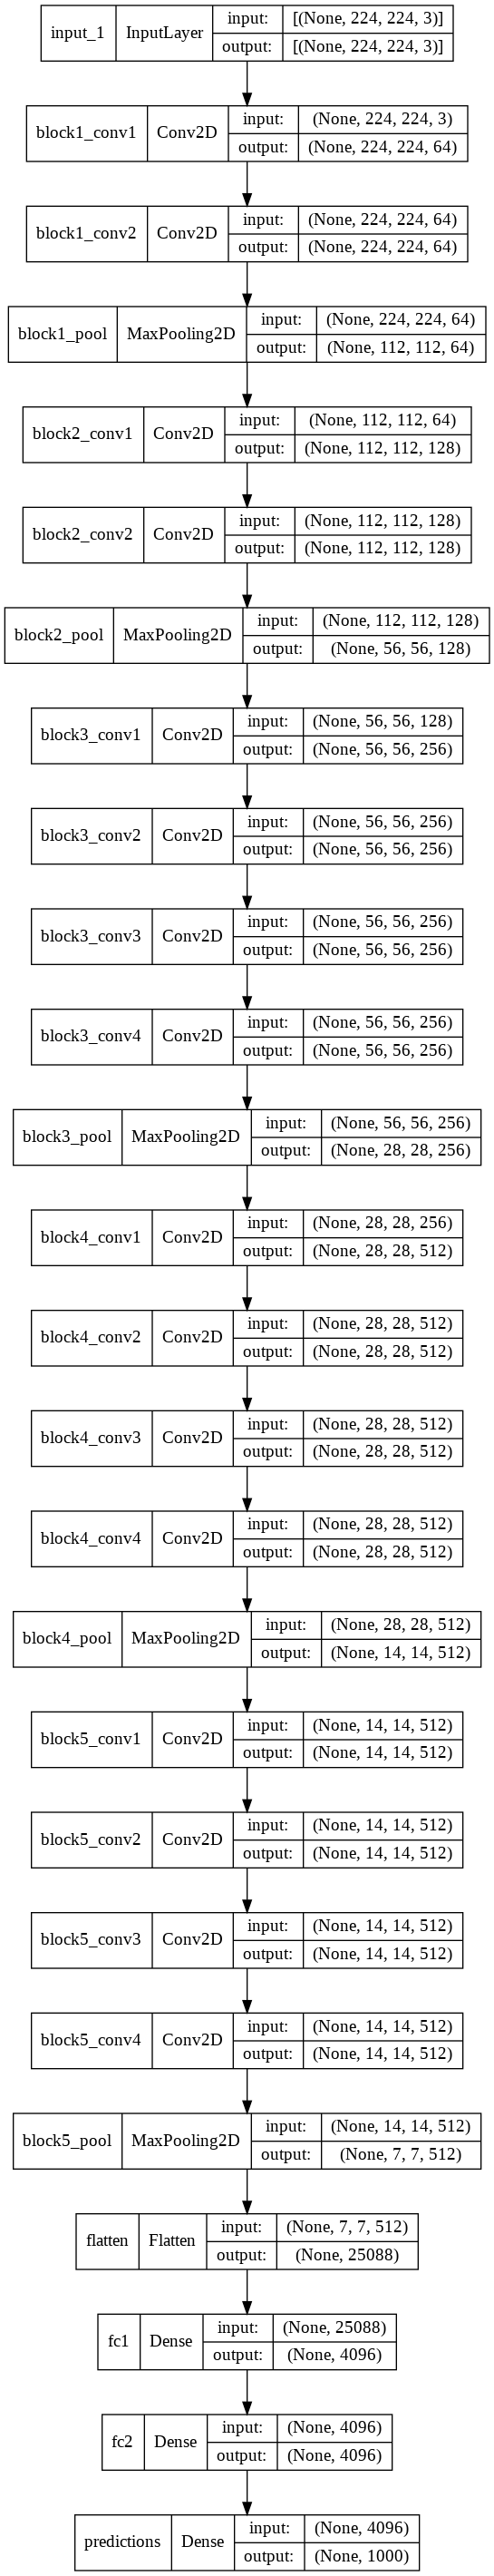

time: 1.5 s (started: 2022-01-11 06:11:45 +00:00)


In [11]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [12]:
# list of layers where we may want to apply rsi-grad-cam
# (listed from input to output)

layer_names = ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']

time: 1.79 ms (started: 2022-01-11 06:11:47 +00:00)


In [13]:
IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3 = model.input.shape[1:]
INPUT_SHAPE = (IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3)
IMAG_SIZE = (IMAGE_SIZE_1, IMAGE_SIZE_2)
print(INPUT_SHAPE, IMAG_SIZE)

(224, 224, 3) (224, 224)
time: 3.3 ms (started: 2022-01-11 06:11:47 +00:00)


# **Display heatmaps**

In [14]:
# baseline is black image
baseline = tf.zeros(shape=INPUT_SHAPE)
baseline = imagenet_utils.preprocess_input(baseline) # for consistency to be used with VGG19 trained with ImageNet - mode: caffe

time: 13.4 ms (started: 2022-01-11 06:11:47 +00:00)


In [15]:
# Instantiate RSI_GradCam for each layer
rsi_gradcam_dict = dict()
for layerName in layer_names:
  rsi_gradcam_dict[layerName] = RSI_GradCAM(model, layerName=layerName, baseline=baseline)

rsi_gradcam_dict['lastLayer'] = RSI_GradCAM(model, baseline=baseline)

time: 27.2 ms (started: 2022-01-11 06:11:47 +00:00)


In [16]:
def display_heatmaps(orig_image,layerName,top_pred=0):

    '''
    inputs are:
    - orig_image = the original image
    - layerName = name of the layer used to generate the heatmap
    - top_pred = which class we what to locate starting a the top predicted,
      i.e., 0 = class with the top (highest) score, 1 = second top, etc.
    '''

    print('layerName =',layerName)
    print()

    orig_bgr = cv2.imread(orig_image) # cv2 loads in BGR format
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB) # transform to RGB

    # load the input image from disk (in Keras/TensorFlow format) 
    # and preprocess it
    image = load_img(orig_image, target_size=IMAG_SIZE) # RGB
    image = img_to_array(image)

    image = np.expand_dims(image, axis=0) # make the image a 1-element batch

    image = imagenet_utils.preprocess_input(image) # default mode: caffe
    # caffe: will convert the images from RGB to BGR, 
    # then will zero-center each color channel with respect 
    # to the ImageNet dataset, without scaling.

    # use the network to make predictions on the input imag and find
    # the class label index with the largest corresponding probability
    preds = model.predict(image)
    
    # select the index of the class we want to locate in the image
    i = np.argsort(preds[0])[-1-top_pred]

    # decode the ImageNet predictions to obtain the human-readable label
    decoded = imagenet_utils.decode_predictions(preds, top=30)

    # uncomment next lines if you want to see the top predictions
    '''
    for j in range(len(decoded[0])):
        print(j, decoded[0][j])
    '''

    (imagenetID, label, prob) = decoded[0][top_pred]
    label = "{}: {:.4f}%".format(label, prob * 100)
    print('image index =', i)
    print()
    print("[INFO] {}".format(label))

    # select rsi-grad-cam
    rsi_gradcam = rsi_gradcam_dict[layerName]

    # produce heatmaps
    _, heatmap_rsi_gradcam = rsi_gradcam.compute_heatmap(image, i)

    # resize the resulting heatmaps to the original input image dimensions
    # and then overlay heatmap on top of the image
    heatmap_rsi_gradcam = cv2.resize(heatmap_rsi_gradcam, (orig_rgb.shape[1], orig_rgb.shape[0]))
    (heatmap_rsi_gradcam, output_rsi_gradcam) = rsi_gradcam.overlay_heatmap(heatmap_rsi_gradcam, orig_rgb, alpha=0.5)

    # display the original image and resulting heatmap and output image
    output_rsi_gradcam = np.vstack([orig_rgb, heatmap_rsi_gradcam, output_rsi_gradcam])
    output_rsi_gradcam = imutils.resize(output_rsi_gradcam, height=700)

    plt.rcParams.update({'font.size':15})
    plt.figure(figsize=(10,10))

    plt.imshow(output_rsi_gradcam)
    plt.title('RSI-Grad-CAM')
    plt.axis('off')

pass

time: 44.4 ms (started: 2022-01-11 06:11:47 +00:00)


The following images contain RSI-Grad-CAM heatmaps obtained a the last three layers, beginning with the closest one to the network output. Note how the heatmaps computed at layers close to the output capture coarser features such as general location of the object, and then finer features such as shapes and edges at layers farther from the output.

In [17]:
orig_image = images_dir + 'pick.jpg'

time: 821 µs (started: 2022-01-11 06:11:47 +00:00)


layerName = block5_pool

49152/35363 [=========================================] - 0s 0us/step
image index = 714

[INFO] pick: 100.0000%


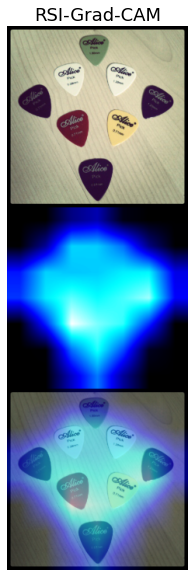

time: 14.1 s (started: 2022-01-11 06:11:47 +00:00)


In [18]:
display_heatmaps(orig_image,layer_names[-1])

Note the contrast between general area ocupied by the picks (above, captured at the last convolutional layer) and individual picks (below, captured at the next to the last layer).

layerName = block4_pool

image index = 714

[INFO] pick: 100.0000%


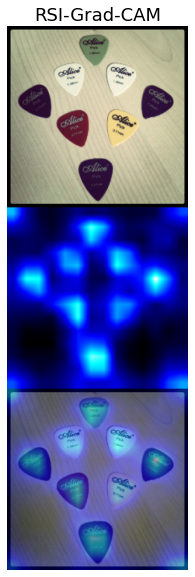

time: 821 ms (started: 2022-01-11 06:12:01 +00:00)


In [19]:
display_heatmaps(orig_image,layer_names[-2])

Next, the heatmap focuses on shapes, such as the pointy structure of the picks, which causes activations to appear at the corners of the square, and edge detections, which causes to highlight the sides of the square, and even the writting in the picks.

layerName = block3_pool

image index = 714

[INFO] pick: 100.0000%


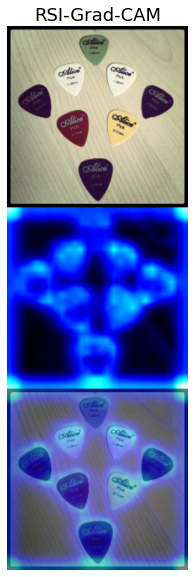

time: 811 ms (started: 2022-01-11 06:12:02 +00:00)


In [20]:
display_heatmaps(orig_image,layer_names[-3])

In [21]:
orig_image = images_dir + 'yellow_ladys_slipper.jpg'

time: 1.42 ms (started: 2022-01-11 06:12:03 +00:00)


Below, an example of object that appears repeated. The heatmap captures the multiple occurences of the objet.

layerName = block5_pool

image index = 986

[INFO] yellow_lady's_slipper: 100.0000%


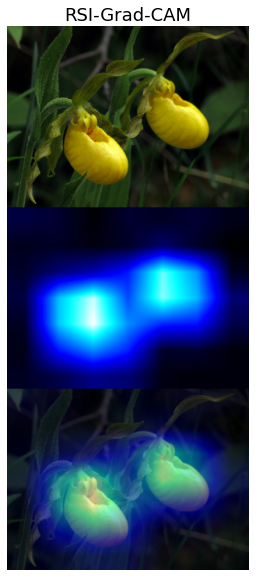

time: 1.19 s (started: 2022-01-11 06:12:03 +00:00)


In [22]:
display_heatmaps(orig_image,layer_names[-1])

layerName = block4_pool

image index = 986

[INFO] yellow_lady's_slipper: 100.0000%


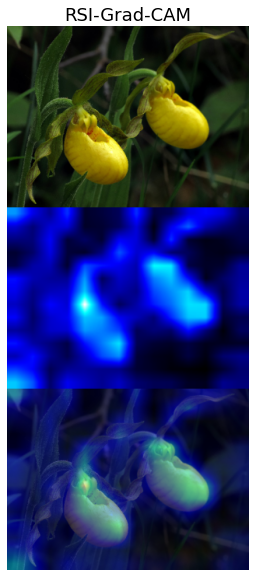

time: 836 ms (started: 2022-01-11 06:12:04 +00:00)


In [23]:
display_heatmaps(orig_image,layer_names[-2])

layerName = block3_pool

image index = 986

[INFO] yellow_lady's_slipper: 100.0000%


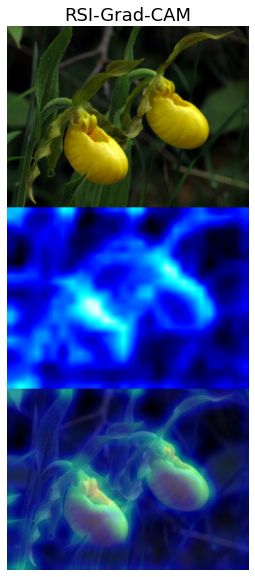

time: 844 ms (started: 2022-01-11 06:12:05 +00:00)


In [24]:
display_heatmaps(orig_image,layer_names[-3])